In [1]:
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import mean_absolute_error as MAE
from sklearn.metrics import mean_absolute_percentage_error as MAPE
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn import preprocessing
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Копия датасета, чтобы не считывать каждый раз файл.
df_copy = pd.read_excel('preprocessed_dataset.xlsx')

In [3]:
df = df_copy
df.head(3)

,full_name,age,height,citizenship,player_agent,current_club,joined,outfitter,social_media,link,...,club_trophies_total_score,club_trophies_average_score,club_trophies_max_score,club_trophies_min_score,club_trophies_amount,Defender_Group,Midfielder_Group,Striker_Group,Winger_Group,followers
0,Joško Gvardiol,22.0,1.85,Croatia,1,Manchester City,7,0,"('Instagram', 'http://www.instagram.com/josko_...",https://www.transfermarkt.com/josko-gvardiol/p...,...,303,37.875,81,8,9,2,0,0,0,1199636
1,Nathan Benjamin Aké,29.0,1.80,Netherlands Cote d'Ivoire,1,Manchester City,43,1,http://www.instagram.com/nathanake/,https://www.transfermarkt.com/nathan-ake/profi...,...,303,37.875,81,8,9,2,0,0,0,2227475
2,Sergio Gómez Martín,23.0,1.71,Spain,1,Manchester City,18,0,http://www.instagram.com/sergiogm_10/,https://www.transfermarkt.com/sergio-gomez/pro...,...,303,37.875,81,8,9,1,0,0,1,475430


In [4]:
# Записываем в y целевую переменную - текущая цена игрока, в X - признаки.
y = df.current_price
X = df.select_dtypes(include='number').drop(columns=['current_price'])

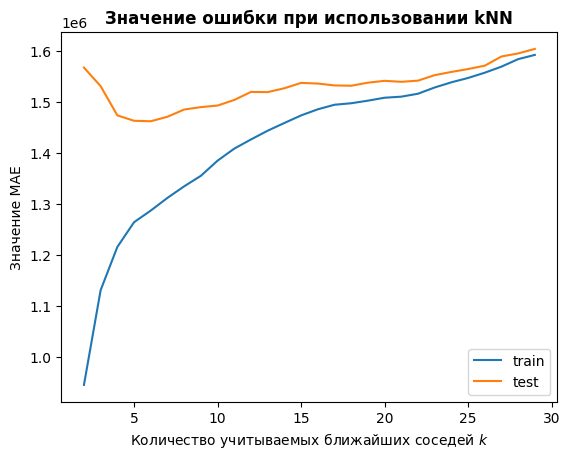

In [5]:
# Попробуем обучить обычный kNN.
K = []
training = []
testing = []
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 123)

for k in range(2, 30):
    clf = KNeighborsRegressor(n_neighbors = k)
    clf.fit(X_train, y_train)

    predict_train = clf.predict(X_train)
    K.append(k)
    training.append(MAE(predict_train, y_train))

    predict_test = clf.predict(X_test)
    testing.append(MAE(predict_test, y_test))

plt.title('Значение ошибки при использовании kNN', weight='bold')
plt.xlabel('Количество учитываемых ближайших соседей $k$')
plt.ylabel('Значение MAE')
plt.plot(K, training, label='train')
plt.plot(K, testing, label='test')
plt.legend()
plt.show()

In [6]:
# В целях попытки улучшения качества, попробуем учитывать ближайших соседей с весами
# Для этого выведем признаки, которые сильнее скоррелированы с ценой на игрока и само значение корреляции.
correlations = df.corr().loc['current_price'].drop('current_price')
most_cor = correlations[abs(correlations.sort_values(ascending=False)) > 0.25].sort_values(ascending=False)
most_cor

club_price                     0.717240
club_trophies_total_score      0.609049
club_trophies_average_score    0.588237
club_trophies_max_score        0.560580
trophies_total_score           0.557781
followers                      0.435210
club_trophies_amount           0.404782
trophies_amount                0.366064
appearances                    0.321600
national                       0.313771
minutes_played                 0.307366
assists                        0.306196
outfitter                      0.303794
national_assists               0.301737
national_status                0.292823
national_goals                 0.278744
goals                          0.277740
national_matches               0.277164
avg_injuries_per_season        0.270376
club_statistics_goals          0.262088
individual                     0.255321
Name: current_price, dtype: float64

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X[most_cor.keys()], y, test_size = 0.3, random_state = 42)
scaler = preprocessing.StandardScaler()
scaler.fit(X_train)
X_train_scaled = pd.DataFrame(scaler.transform(X_train), columns=most_cor.keys())
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=most_cor.keys())

In [8]:
for column in most_cor.keys():
  X_train_scaled[column] = X_train_scaled[column] * most_cor[column]
  X_test_scaled[column] = X_test_scaled[column] * most_cor[column]

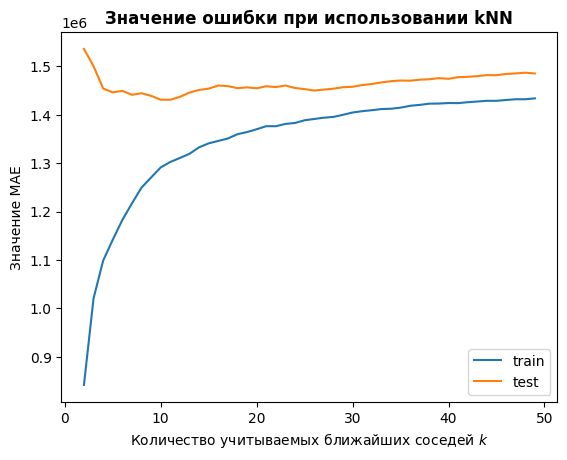

In [9]:
training = []
K = []
testing = []
for k in range(2, 50):
    clf = KNeighborsRegressor(n_neighbors = k)
    clf.fit(X_train_scaled, y_train)

    predict_train = clf.predict(X_train_scaled)
    K.append(k)
    training.append(MAE(predict_train, y_train))

    predict_test = clf.predict(X_test_scaled)
    testing.append(MAE(predict_test, y_test))

plt.title('Значение ошибки при использовании kNN', weight='bold')
plt.xlabel('Количество учитываемых ближайших соседей $k$')
plt.ylabel('Значение MAE')
plt.plot(K, training, label='train')
plt.plot(K, testing, label='test')
plt.legend()
plt.show()

In [10]:
# По данному графику наиболее оптимальным значением
# гиперпараметра k является значение 10, сохраним модель.
# Сохранение модели в файл формата .pkl
import pickle
clf = KNeighborsRegressor(n_neighbors = 10)
clf.fit(X_train_scaled, y_train)
best_knn = clf
with open('best_knn_model.pkl', 'wb') as file:
    pickle.dump(best_knn, file)

In [11]:
# Вывод основных метрик
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import mean_absolute_error as MAE
from sklearn.metrics import r2_score as R2
from sklearn.metrics import median_absolute_error as MEDAE
from sklearn.metrics import explained_variance_score as EVS
from sklearn.metrics import mean_absolute_percentage_error as MAPE

best_predictions = best_knn.predict(X_test_scaled)
def RMSE(y_true, y_pred):
    return np.sqrt(MSE(y_true, y_pred))

print("RMSE:", RMSE(y_test, best_predictions))
print("MAE:", MAE(y_test, best_predictions))
print("R^2:", R2(y_test, best_predictions))
print("MEDAE:", MEDAE(y_test, best_predictions))
print("EVS:", EVS(y_test, best_predictions))
print("MAPE:", MAPE(y_test, best_predictions))

RMSE: 4811010.525168889
MAE: 1431116.1710037175
R^2: 0.6134409384038357
MEDAE: 204250.0
EVS: 0.6141716121082894
MAPE: 1.6832958447561912
